# Weather Data Classification

This notebook demonstrates the implementation of a Convolutional Neural Network (CNN) to classify weather data by month based on temperature patterns. The model uses air temperature data from 1981 to learn and predict which month a given temperature pattern belongs to.

In [28]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from huggingface_hub import hf_hub_download

## Required Libraries

This section imports the necessary Python libraries:
- `xarray`: For handling NetCDF data files
- `numpy`: For numerical computations
- `matplotlib.pyplot`: For data visualization
- `torch`: PyTorch deep learning framework
- `tqdm`: For progress bars during training
- `huggingface_hub`: For downloading the dataset

In [40]:
file_path = hf_hub_download(repo_id="Mignar/weather-data", filename="air.2m.1981.nc", repo_type="dataset")

# Load NetCDF dataset
ds_20cr = xr.open_dataset(file_path)
ds_20cr

<xarray.Dataset> Size: 761MB
Dimensions:    (lat: 181, lon: 360, time: 2920, nbnds: 2)
Coordinates:
  * lat        (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lon        (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time       (time) datetime64[ns] 23kB 1981-01-01 ... 1981-12-31T21:00:00
Dimensions without coordinates: nbnds
Data variables:
    air        (time, lat, lon) float32 761MB ...
    time_bnds  (time, nbnds) float64 47kB ...
Attributes: (12/24)
    Conventions:               CF-1.2
    title:                     8x Daily NOAA/CIRES/DOE 20th Century Reanalysi...
    comments:                  Data are from \nNOAA/CIRES/DOE 20th Century Re...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   These data are available free of charge under ...
    spatial_resolution:        1.0 degree
    ...                        ...
    citation1:                 Slivinski, L. C, G. P. Compo, J. S. Whitaker, ...
    References:                https://www.psl.noaa.gov/data/gridded/data.20t...
    creator_name:              NOAA/PSL
    institution:               NOAA Physical Sciences Laboratory & CU/CIRES \...
    contact:                   psl.data@noaa.gov
    citation:                  Compo,G.P. <https://www.psl.noaa.gov/people/gi...

## Data Loading

The weather data is downloaded from the Hugging Face Hub and loaded using xarray. The dataset contains air temperature measurements from 1981.

In [41]:
def create_dataset(ds, field_name='air'):
    n_time, n_lon, n_lat = ds[field_name].shape

    targets = torch.tensor([int(str(d).split("-")[1])-1 for d in ds_20cr.air.time.values])
    #targets = torch.empty(n_time, dtype=torch.long)
    #for i in range(n_time):
    #    targets[i] = int(str(ds["time"].values[i]).split("-")[1]) - 1

    data = torch.as_tensor(ds[field_name].values.reshape(n_time, 1, n_lon, n_lat))
    data = F.interpolate(data, size=(72, 72), mode='bilinear', align_corners=False)
    data = (data - 273.15) / 20.5
    dataset = torch.utils.data.TensorDataset(data, targets)

    return dataset, n_time

data_20cr, n_time = create_dataset(ds_20cr)
    

## Data Preprocessing

The `create_dataset` function processes the raw weather data:
1. Extracts the dimensions (time, longitude, latitude)
2. Creates target labels (0-11) from the months in the timestamps
3. Reshapes the data into a format suitable for CNN (batch, channels, height, width)
4. Resizes images to 72x72 using bilinear interpolation
5. Normalizes temperature data by converting from Kelvin to Celsius and scaling
6. Creates a PyTorch TensorDataset with features and labels

In [42]:
n_test = int( n_time * 0.1 )
n_validation = int( n_time * 0.1 )
n_training = n_time - n_test - n_validation
training_data, validation_data, test_data = torch.utils.data.random_split(data_20cr, [n_training, n_validation, n_test])

## Dataset Splitting

The dataset is split into three parts:
- Training set (80%): Used to train the model
- Validation set (10%): Used to monitor training progress and prevent overfitting
- Test set (10%): Used for final model evaluation

In [43]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=n_test, shuffle=False)

## Model Architecture

The CNN model (`Classify` class) consists of:
1. Two convolutional layers with ReLU activation and max pooling
   - Conv1: 1 input channel → 6 feature maps (3x3 kernel)
   - Conv2: 6 channels → 16 feature maps (3x3 kernel)
   - MaxPool: 2x2 window after each conv layer
2. Three fully connected layers
   - FC1: 16 × 16 × 16 → 120 units
   - FC2: 120 → 84 units
   - FC3: 84 → 12 units (one per month)

The model produces logits for each month class, which are then used with CrossEntropyLoss for training.

In [45]:
import torch.nn as nn
# We import the ReLU activation function
from torch.nn.functional import relu


class Classify(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16*16*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 12)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.fc1(x.reshape(x.shape[0],-1)))
        x = self.relu(self.fc2(x))
        #y = self.softmax(self.fc3(x))
        y = self.fc3(x)
        return y
        

In [46]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = Classify()
model.to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 50
train_loss = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)

Using device: mps


## Model Training Setup

This section:
1. Sets up the device (MPS, CUDA, or CPU) for model training
2. Initializes the model and moves it to the selected device
3. Configures the loss function (CrossEntropyLoss) and optimizer (SGD with momentum)
4. Initializes arrays to track training and validation losses

In [47]:
model.train()
for epoch in tqdm(range(num_epochs)):
    
    for i, data in enumerate(train_dataloader, 0):
        X, target = data
        X = X.to(device)
        target = target.to(device)
        optimizer.zero_grad()

        y_pred = model(X)
        loss = loss_fn(y_pred, target)
        loss.backward()
        optimizer.step()

        train_loss[epoch] += loss.item()
        
    train_loss[epoch] /= len(train_dataloader)
    
    with torch.no_grad():
        for val in validation_dataloader:
            X_val, target_val = val
            X_val = X_val.to(device)
            target_val = target_val.to(device)
            y_pred_val = model(X_val)
            loss_val = loss_fn(y_pred_val, target_val)
            val_loss[epoch] += loss_val.item()
            
    val_loss[epoch] /= len(validation_dataloader)



100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


## Training Loop

The training process:
1. For each epoch:
   - Train the model on batches of training data
   - Calculate and accumulate training loss
   - Run validation on validation dataset
   - Calculate and accumulate validation loss
2. Both losses are normalized by their respective dataloader lengths
3. Training is performed for 50 epochs

In [48]:
train_loss

array([2.47809888, 2.41637475, 1.8311015 , 1.26034144, 0.77838002,
       0.5184641 , 0.37925526, 0.35070531, 0.27113736, 0.22501864,
       0.22395717, 0.21039516, 0.26158633, 0.16125538, 0.15034867,
       0.14618589, 0.15347476, 0.1050772 , 0.1031515 , 0.10455307,
       0.07114245, 0.11733593, 0.08610897, 0.05912362, 0.07417332,
       0.08212208, 0.09926301, 0.05407318, 0.05877366, 0.12222446,
       0.06371951, 0.06826278, 0.02926625, 0.06366139, 0.07485987,
       0.03548227, 0.065234  , 0.06116131, 0.05839633, 0.04622836,
       0.03342455, 0.040524  , 0.03237915, 0.031494  , 0.03673333,
       0.03820979, 0.03930405, 0.05337924, 0.02084193, 0.0293132 ])

Text(0, 0.5, 'Loss')

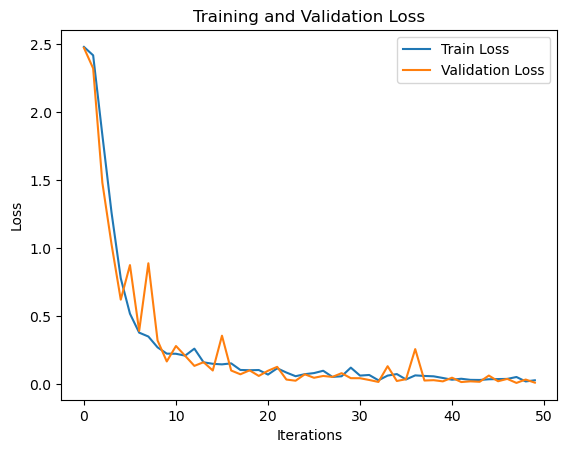

In [54]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Iterations")
plt.title("Training and Validation Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.ylabel("Loss")

In [55]:
data, label = next(iter(train_dataloader))
data = data.to(device)
label = label.to(device)
y_pred = model(data)
y_pred.max(dim=1)

torch.return_types.max(
values=tensor([15.9439, 22.9054, 30.2325, 20.5846, 26.8436, 22.2373, 30.2789, 26.8682,
        24.9344, 26.3211, 30.3031, 24.5811, 16.7277, 21.6415, 32.2217, 26.6876],
       device='mps:0', grad_fn=<MaxBackward0>),
indices=tensor([ 6,  9,  0,  4,  4, 10,  7,  1,  8,  4,  2,  4,  6,  5,  0, 11],
       device='mps:0'))

In [56]:
y_pred[9]

tensor([-13.7773,  -3.3874,   0.1353,  15.6040,  26.3211,  11.2842,  -9.6706,
        -14.2726,   2.1653,   1.4481, -13.2124,  -6.2421], device='mps:0',
       grad_fn=<SelectBackward0>)

In [58]:
def get_score(data_loader, data_type):
    model.eval()
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for i, data in enumerate(data_loader, 0):
            inputs, labels = [x.to(device) for x in data]
            # We applied our trained model to each batch of samples
            scores = model(inputs)
            # The shape of scores is (16, 12) = (batch_size, number_of_months)
            # From each sample of the batch (first axis), 
            # get the index of the output with highest value (most probable month)
            _, predictions = scores.max(1)
            num_correct += (predictions == labels).sum()
            num_samples += predictions.size(0)
        print("Accuracy {}: {:.2f}%".format(data_type, 100 * num_correct / num_samples))

## Model Evaluation

The `get_score` function evaluates the model's performance by:
1. Setting the model to evaluation mode
2. Processing batches of data without gradient calculation
3. Computing predictions for each batch
4. Calculating accuracy as the percentage of correct predictions
5. Displaying the accuracy for the specified dataset (training or test)

In [59]:
get_score(train_dataloader, "training dataset")
get_score(test_dataloader, "test dataset")

Accuracy training dataset: 99.40%
Accuracy test dataset: 99.32%


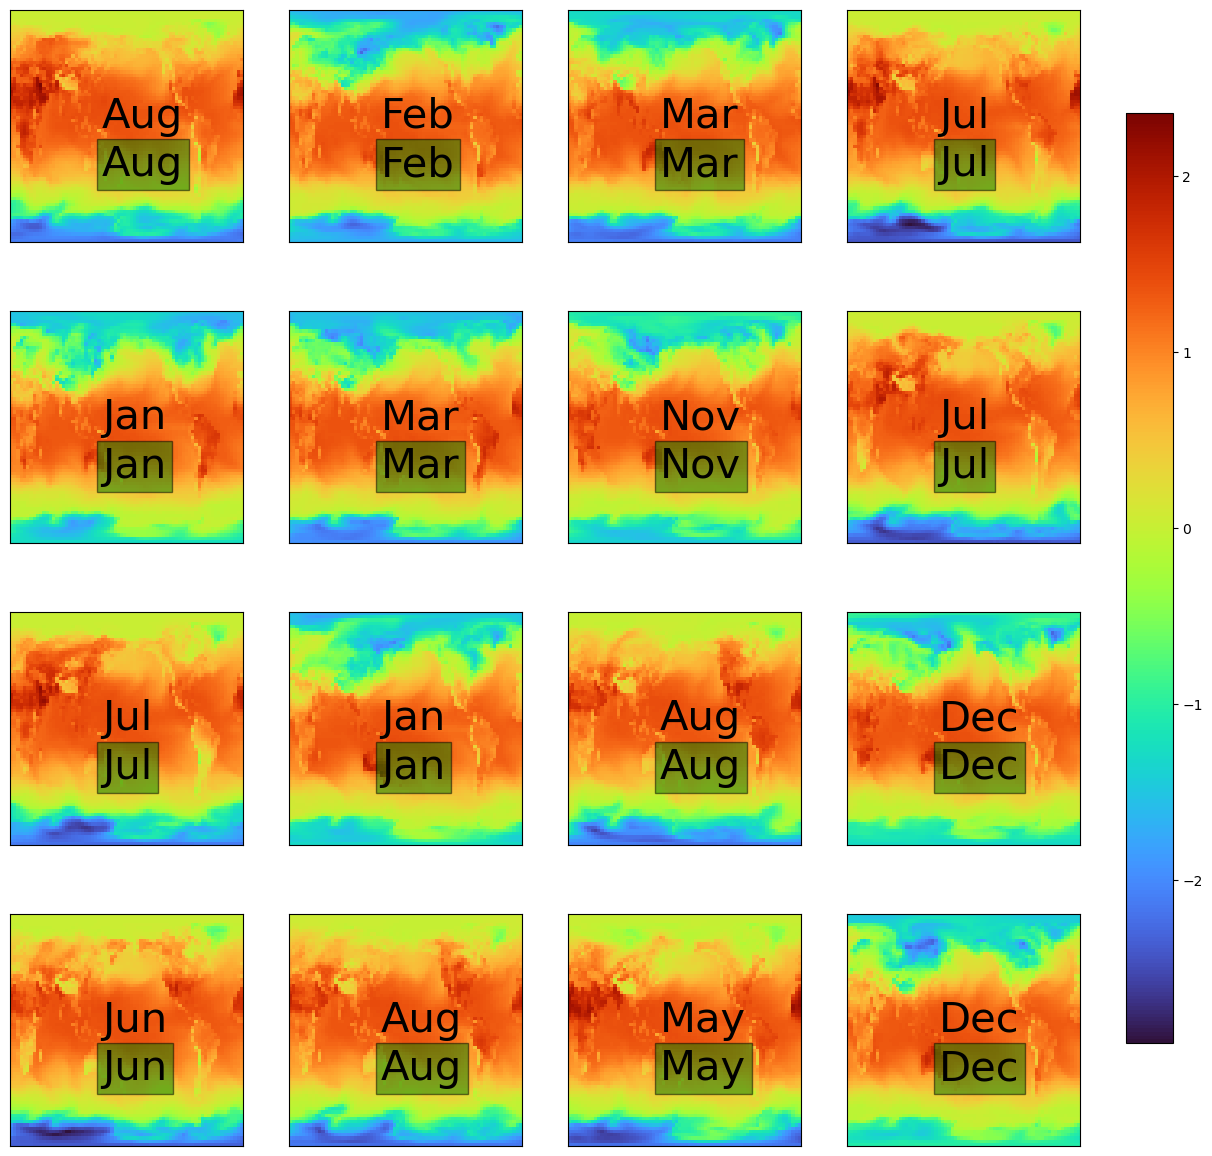

In [60]:
from plotlib import plot_data
dataiter = iter(test_dataloader)
data_batch, labels = [x.to(device) for x in next(dataiter)]
_, predictions = model(data_batch).max(1)
plot_data(data_batch[:16], labels[:16], predictions)